In [16]:
import re
import os
from bidict import bidict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import scipy.io.wavfile as wavfile

In [2]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support, precision_score, make_scorer, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

import warnings
warnings.filterwarnings("ignore")

In [3]:

data_path = "./data/crcns/aa2/"
stims_path = os.path.join(data_path, "all_stims")
cells_path = os.path.join(data_path, "all_cells")

brain_area_mapping = {
    'OV': 'nucleus ovoidalis',
    'L3': 'Primary Forebrain (L3)',
    'mld': 'mesencephalicus lateralis dorsalis',
    'CM': 'Caudal Mesopallium',
    'None': 'None',
    'L2a': 'Primary Forebrain (L2a)',
    'L': 'Primary Forebrain (L)',
    'L1': 'Primary Forebrain (L1)',
    'L2b': 'Primary Forebrain (L2b)',
}

def listdir(path):
    return [x for x in os.listdir(path) if not x.startswith(".")]

def get_region(regions_df, cell_id):
    regions = regions_df[regions_df.index == cell_id]["region"].values
    assert len(regions) == 1, f"Unexpected number of regions: {len(regions)}"
    return brain_area_mapping[regions[0]]

def get_main_df():
    d = {"Cell ID": [], "Brain Region": [], "Stimulus Type": [], "Stimulus File": [], "Spike File": [], "Average Spikes": []}

    cell_regions_df = pd.read_csv(os.path.join(data_path, "cell_regions.csv"), header=None, index_col=0)
    cell_regions_df.columns = ["region"]
    cell_regions_df.index.name = "Cell ID"

    cells = listdir(cells_path)
    for cell in cells:
        stim_types = listdir(os.path.join(cells_path, cell))
        for stim_type in stim_types:
            cell_stimuli_paths = []
            spike_paths = []

            stim_files = listdir(os.path.join(cells_path, cell, stim_type))
            for stim_file in stim_files:
                if stim_file.startswith("spike"):
                    spike_paths.append(os.path.join(cells_path, cell, stim_type, stim_file))
                elif stim_file.startswith("stim"):
                    cell_stimuli_paths.append(os.path.join(cells_path, cell, stim_type, stim_file))
                else:
                    assert False, f"Unexpected file prefix: {stim_file}"

            spike_paths.sort()
            cell_stimuli_paths.sort()

            for spike_path, stim_path in zip(spike_paths, cell_stimuli_paths):
                spike_index = re.search(r"\d+", stim_path).group(0)
                stim_index = re.search(r"\d+", spike_path).group(0)                
                assert spike_index == stim_index and spike_index != None, f"Index mismatch: stim index: {stim_index}, spike index: {spike_index}"

                with open(stim_path, "r") as f:
                    stim_file_path = os.path.join(stims_path, f.read().strip())

                with open(spike_path, "r") as f:
                    spike_trials = f.read().splitlines()

                lens = []
                for trial in spike_trials:
                    trial_spikes = 0
                    for spike in trial.split():
                        if spike != "" and float(spike) >= 0:
                            trial_spikes += 1

                    lens.append(trial_spikes)

                d["Cell ID"].append(cell)
                d["Brain Region"].append(get_region(cell_regions_df, cell))
                d["Stimulus Type"].append(stim_type)
                d["Average Spikes"].append(np.average(lens))
                d["Stimulus File"].append(stim_file_path)
                d["Spike File"].append(spike_path)

    return pd.DataFrame(d).set_index("Cell ID")

df = get_main_df()

In [4]:
def plot_entry(index):
    entry = df.iloc[index]
    with open(entry['Spike File'], 'r') as f:
        times = [float(y) for x in [f.read().split('\n')[0]] for y in x.split()]

    print(entry['Spike File'])

    # Plot the spikes
    plt.vlines(times, 0, 1, color='black')
    
    plt.show()

In [5]:
max_times = []
for i in range(len(df)):
    with open(df.iloc[i]["Spike File"], "r") as f:
        max_times.append(max([float(y) for x in f.read().split('\n') for y in x.split()]))

max_time = int(max(max_times)) + 1

In [6]:
cell_ids = bidict({cell_id: i for i, cell_id in enumerate(set(df.index))})
brain_regions = bidict({region: i for i, region in enumerate(set(df["Brain Region"]))})
stimulus_types = bidict({stimulus: i for i, stimulus in enumerate(set(df["Stimulus Type"]))})

In [7]:
d = {"Cell ID": [], "Brain Region": [], "Number of Spikes": []}
d.update({str(x): [] for x in range(max_time)})
y = []

for i in range(len(df)):
    cell_id = df.index[i]
    brain_region = df.iloc[i]["Brain Region"]
    stimulus_type = df.iloc[i]["Stimulus Type"]

    with open(df.iloc[i]["Spike File"], "r") as f:
        trials = f.readlines()
        for trial in trials:
            d["Cell ID"].append(cell_ids[cell_id])
            d["Brain Region"].append(brain_regions[brain_region])
            d["Number of Spikes"].append(len(trial.split()))
            y.append(1 if stimulus_type == "conspecific" else 0)

            times = {int(float(time)) for time in trial.split()}
            for time in range(max_time):
                if time in times:
                    d[str(time)].append(1)
                else:
                    d[str(time)].append(0)
        
X = pd.DataFrame(d)

X_backup = X.copy()
y_backup = y.copy()

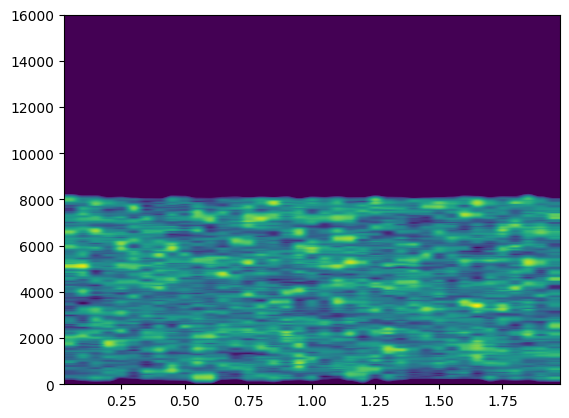

In [21]:

# def plot_spectrogram(signal, sf, ax, window_sec=0.1, maxy=10000, overlap=0.5):
#   nfft = int(window_sec * sf)
#   noverlap = int(nfft * overlap)  # overlap set to be half of a segment
#   nfft_padded = next_power_of_2(nfft)  # pad segment with zeros for making nfft of power of 2 (better performance)
#   vmin = 20*np.log10(np.max(signal)) - 90  # hide anything below -90 dBc

#   Sxx, f, t, img = ax.specgram(signal, Fs=sf, NFFT=nfft, noverlap=noverlap,
#               pad_to=nfft_padded, mode='magnitude', vmin=vmin)

#   return Sxx, f, t

def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()

def audio_response(signal, sf, window_sec=0.1, maxy=10000, overlap=0.5):
  figure, ax = plt.subplots()
  nfft = int(window_sec * sf)
  noverlap = int(nfft * overlap)  # overlap set to be half of a segment
  nfft_padded = next_power_of_2(nfft)  # pad segment with zeros for making nfft of power of 2 (better performance)
  vmin = 20*np.log10(np.max(signal)) - 90  # hide anything below -90 dBc

  return ax.specgram(signal, Fs=sf, NFFT=nfft, noverlap=noverlap,
                pad_to=nfft_padded, mode='magnitude', vmin=vmin)

path = df.iloc[0]["Stimulus File"]
frog_sf, frog_samples = wavfile.read(path)
Sxx, f, t, _ = audio_response(frog_samples, frog_sf)

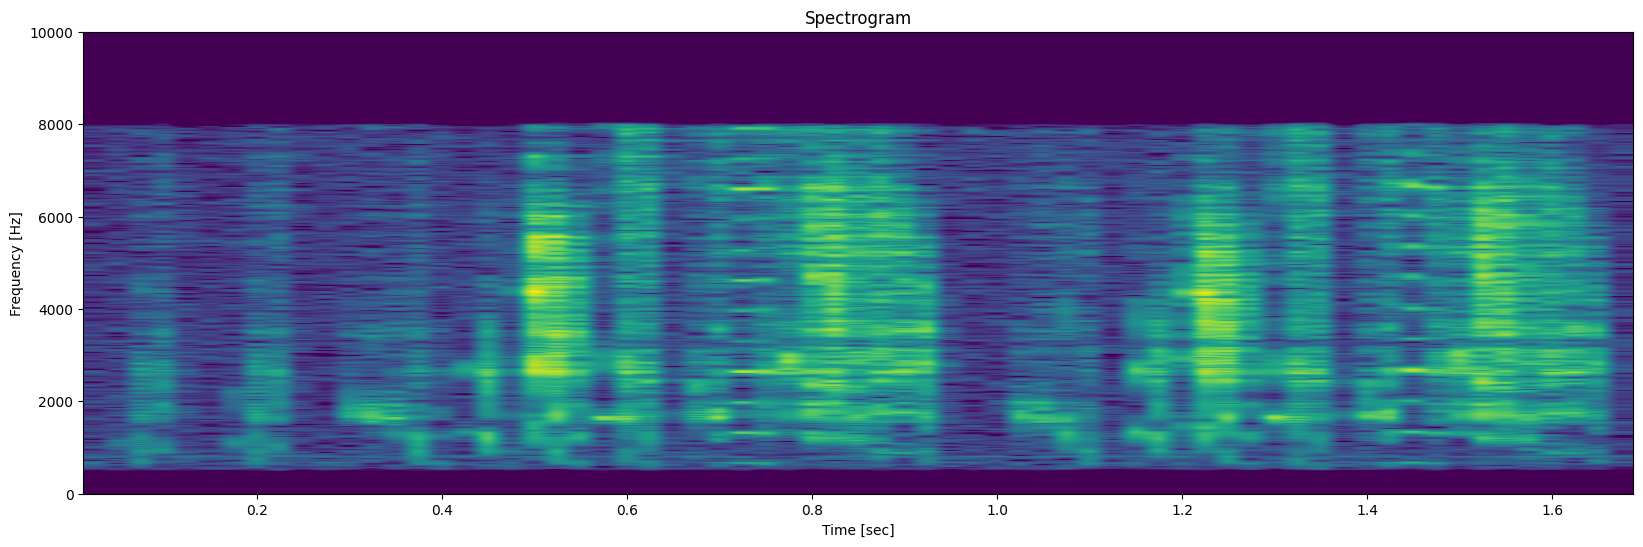

In [37]:
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()


def plot_spectrogram(signal, sf, ax: plt.Axes, window_sec=0.1, maxy=10000, overlap=0.5):
  """Plot spectrogram and return the calculation values"""
  nfft = int(window_sec * sf)
  noverlap = int(nfft * overlap)  # overlap set to be half of a segment
  nfft_padded = next_power_of_2(nfft)  # pad segment with zeros for making nfft of power of 2 (better performance)
  vmin = 20*np.log10(np.max(signal)) - 90  # hide anything below -90 dBc

  Sxx, f, t, img = ax.specgram(signal, Fs=sf, NFFT=nfft, noverlap=noverlap,
              pad_to=nfft_padded, mode='magnitude', vmin=vmin)

  ax.set_ylim([0, maxy])
  ax.set_ylabel('Frequency [Hz]')
  ax.set_xlabel('Time [sec]')
  ax.set_title('Spectrogram')

  return Sxx, f, t

def audio_response(description, wav_samples, wav_sf):
  fig, ax = plt.subplots(1,1,figsize=(20, 6))
  Sxx, f, t = plot_spectrogram(wav_samples, wav_sf, ax, window_sec=0.05, overlap=0.5)
  plt.show()
  return Sxx, f, t

frog_sf, frog_samples = wavfile.read(path)
Sxx, f, t = audio_response('knudsens frog', frog_samples, frog_sf)

In [50]:
Sxx[260].shape

(67,)

In [55]:
import librosa

librosa.get_duration(filename=df[df["Stimulus Type"] == "conspecific"].iloc[0]["Stimulus File"])

1.72203125

In [58]:
from tqdm import tqdm


max_times = []
for i in tqdm(range(len(df))):
    max_times.append(int(librosa.get_duration(filename=df.iloc[i]["Stimulus File"])))

max_time = int(max(max_times)) + 1

  0%|          | 0/18982 [00:00<?, ?it/s]

100%|██████████| 18982/18982 [01:47<00:00, 177.02it/s]


In [59]:
max_time

3